# Compare active fires to validation polys

#inputs: 
   mask: NDVI<.7 prior to harvest (clearest Aug/Sept Sentinel image)
   valid_polys = shp / gpkg of validation polygons with attribute for day of (first collect polys and mask with urban/dark)


In [2]:
import sys
import os
import osgeo  # needed only if running from Windows
from pathlib import Path
#from shapely.geometry import box
import geopandas as gpd
#import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.append(r"cropburn")
#from planet_obs_stats import *
from timeseries import *

## order and download active fire data from NASA FIRMS website
###   Unzip folder and change link to active_fire_dir below. (current link is a sample dataset)
### (see readme that comes with download for more info on product)

In [4]:
active_fire_dir = os.path.join(r'data','active_fires')

In [5]:
#grid_file = r"data/Grid_Punjab_UTM.gpkg"
aoi_file = os.path.join(r'data','AOIs','cell31.shp')

In [6]:
viirs_file = [f for f in os.listdir(active_fire_dir) if f.startswith('fire_archive_SV-C2') and f.endswith('.shp')]
modis_file = [f for f in os.listdir(active_fire_dir) if f.startswith('fire_archive_M') and f.endswith('.shp')]

## if aoi is single polygon shapefile:
viirs = gpd.read_file(os.path.join(active_fire_dir,viirs_file[0]))
modis = gpd.read_file(os.path.join(active_fire_dir,modis_file[0]))

aoi = gpd.read_file(aoi_file)
print("viirs data are in:", viirs.crs)
print("original aoi file is in:", aoi.crs)
if aoi.crs != viirs.crs:
    aoi = aoi.to_crs(viirs.crs)
print("aoi file is now in:", aoi.crs)

viirs data are in: EPSG:4326
original aoi file is in: EPSG:7773
aoi file is now in: EPSG:4326


## crop active fire data to aoi:

In [ ]:
#viirs_clip = get_pts_in_grid (grid_file, 31, viirs_file)

In [7]:
viirs_clip = gpd.clip(viirs, aoi)
print ('there are {} active fire points in this period for this aoi'.format(len(viirs_clip)))
viirs_clip.head()

there are 166 active fire points in this period for this aoi


,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,day,mo,dos,geometry
37417,30.471071,74.956268,342.60,0.39,0.44,2019-11-04,0824,N,VIIRS,n,1,301.11,7.54,D,0,4,11,26.0,POINT (74.95627 30.47107)
32828,30.476761,74.970390,342.91,0.37,0.58,2019-11-03,0842,N,VIIRS,n,1,291.34,2.27,D,0,3,11,25.0,POINT (74.97039 30.47676)
48662,30.477396,74.971016,333.64,0.46,0.39,2019-11-06,0748,N,VIIRS,n,1,301.65,6.58,D,0,6,11,28.0,POINT (74.97102 30.47740)
65827,30.471153,74.958527,331.68,0.34,0.56,2019-11-18,0724,N,VIIRS,n,1,300.64,1.58,D,0,18,11,40.0,POINT (74.95853 30.47115)
70468,30.475355,74.930885,327.66,0.39,0.36,2019-11-21,0806,N,VIIRS,n,1,295.15,1.89,D,0,21,11,43.0,POINT (74.93089 30.47536)


In [8]:
modis_clip = gpd.clip(modis, aoi)
print ('there are {} active fire points in this period for this aoi'.format(len(modis_clip)))
modis_clip.head()

there are 28 active fire points in this period for this aoi


,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
12011,30.4784,74.8745,320.5,1.0,1.0,2019-11-11,0818,Aqua,MODIS,67,6.03,276.2,17.3,D,0,POINT (74.87450 30.47840)
8390,30.4764,74.9720,320.7,1.0,1.0,2019-11-04,0811,Aqua,MODIS,33,6.03,300.5,9.9,D,0,POINT (74.97200 30.47640)
11400,30.4796,74.9489,316.1,1.3,1.1,2019-11-09,0830,Aqua,MODIS,65,6.03,304.1,8.8,D,0,POINT (74.94890 30.47960)
12974,30.4866,74.9236,318.7,1.1,1.0,2019-11-18,0824,Aqua,MODIS,70,6.03,301.4,9.7,D,0,POINT (74.92360 30.48660)
8426,30.4864,74.9157,320.1,1.0,1.0,2019-11-04,0811,Aqua,MODIS,22,6.03,301.0,9.3,D,0,POINT (74.91570 30.48640)


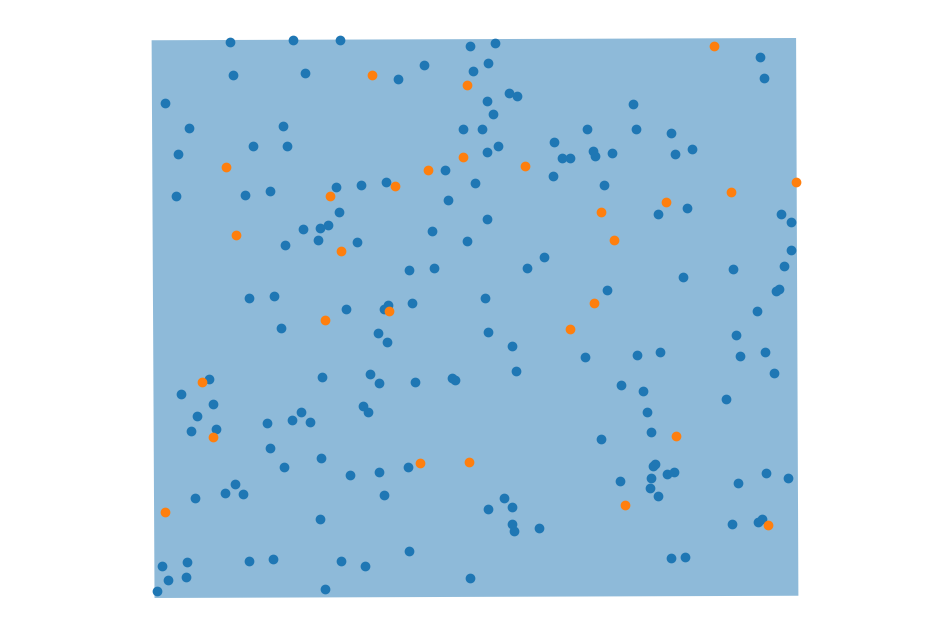

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
aoi.plot(ax=ax, alpha=.5)
viirs_clip.plot(alpha=1, ax=ax)
modis_clip.plot(alpha=1, ax=ax)
plt.axis('equal')
ax.set_axis_off()
plt.show()

## make histogram of fires by day

In [9]:
viirs_bydate = viirs_clip.groupby(['ACQ_DATE'])['ACQ_DATE'].size().reset_index(name='counts')
print ('there are {} burn days observed in this season'.format(len(viirs_bydate)))
viirs_bydate["obs_date"] = pd.to_datetime(viirs_bydate['ACQ_DATE'])
viirs_bydate.set_index("obs_date", inplace=True)

season_first = viirs_bydate.index[0]
season_last = viirs_bydate.index[-1]
print('the season is from {} to {}'.format(season_first, season_last))
print('the season is {} days'.format( (viirs_bydate.index[-1] - viirs_bydate.index[0] ).days))

viirs_bydate.head()

there are 15 burn days observed in this season
the season is from 2019-10-23 00:00:00 to 2019-11-21 00:00:00
the season is 29 days


,ACQ_DATE,counts
obs_date,,
2019-10-23,2019-10-23,2
2019-10-27,2019-10-27,1
2019-10-29,2019-10-29,3
2019-10-30,2019-10-30,4
2019-11-03,2019-11-03,36


In [18]:
viirs_doy = convert_timeseries_to_doy(viirs_bydate, 2019, start_day=283, end_day=354, season=True)

from datetime import datetime as dt
from datetime import timedelta as td

start = dt.strptime("10-10-2019", "%d-%m-%Y")
end = dt.strptime("20-12-2019", "%d-%m-%Y")
print(f'range is {end-start}')
date_labels = [((start - td(days=1)) + td(days=x)).strftime('%d-%m') for x in range(0,(end-start).days,2)]

range is 71 days, 0:00:00


In [11]:
modis_bydate = modis_clip.groupby(['ACQ_DATE'])['ACQ_DATE'].size().reset_index(name='counts')
print ('there are {} burn days observed in this season'.format(len(modis_bydate)))
modis_bydate["obs_date"] = pd.to_datetime(modis_bydate['ACQ_DATE'])
modis_bydate.set_index("obs_date", inplace=True)
modis_doy = convert_timeseries_to_doy(modis_bydate, 2019, start_day=283, end_day=354, season=True)
modis_doy.head()

there are 9 burn days observed in this season


,ACQ_DATE,counts
obs_date,,
17,2019-10-26,1
22,2019-10-31,3
26,2019-11-04,15
27,2019-11-05,1
28,2019-11-06,1


In [17]:
planet_ba_file = os.path.join(r'data','Walker2023RS','Img_Lists','ba_31_planet.csv')
planet_ba = pd.read_csv(planet_ba_file)
planet_ba.head()
planet_ba["obs_date"] = pd.to_datetime(planet_ba["burn_date"])
planet_ba.set_index("obs_date",inplace=True)
planet_doy = convert_timeseries_to_doy(planet_ba, 2019, start_day=283, end_day=354, season=True)
planet_doy['ha'].sort_values(ascending=False).head()

obs_date
30    783.0
26    692.0
23    336.0
28    299.0
27    294.0
Name: ha, dtype: float64

## add PM2 data (for underlay):

In [14]:
pollution_data = pd.read_csv('./data/PM25/Punjab_Bhatinda.csv', usecols=['From Date', 'PM2.5'])
# change 'None' to legit NaNs:
pollution_data["PM2.5"] = pd.to_numeric(pollution_data["PM2.5"], errors='coerce')
# convert to time series:
pollution_data['From Date'] = pd.to_datetime(pollution_data['From Date'])
pollution_ts = pollution_data[pollution_data['From Date'] > pd.Timestamp(2019,10,9)]
pollution_daily = pollution_ts.set_index('From Date').resample('D')['PM2.5'].mean()
#pollution_daily.dropna(axis=0, inplace=True)
#pollution_daily = pollution_daily.astype(np.int64)
print('max PM2.5 value is {}, Min value is {}'.format(pollution_daily.max(), pollution_daily.min()))
pollution_doy = convert_timeseries_to_doy(pollution_daily, 2019, start_day=283, end_day=343, season=True)
pollution_doy.head()

max PM2.5 value is 223.0695, Min value is 11.397333333333334


From Date
1    27.234583
2    70.958750
3    58.074167
4    35.095417
5    38.424167
Name: PM2.5, dtype: float64

C:\Users\klobw\AppData\Local\Temp\ipykernel_53980\61993069.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(date_labels, rotation='vertical', fontname='Palatino Linotype')


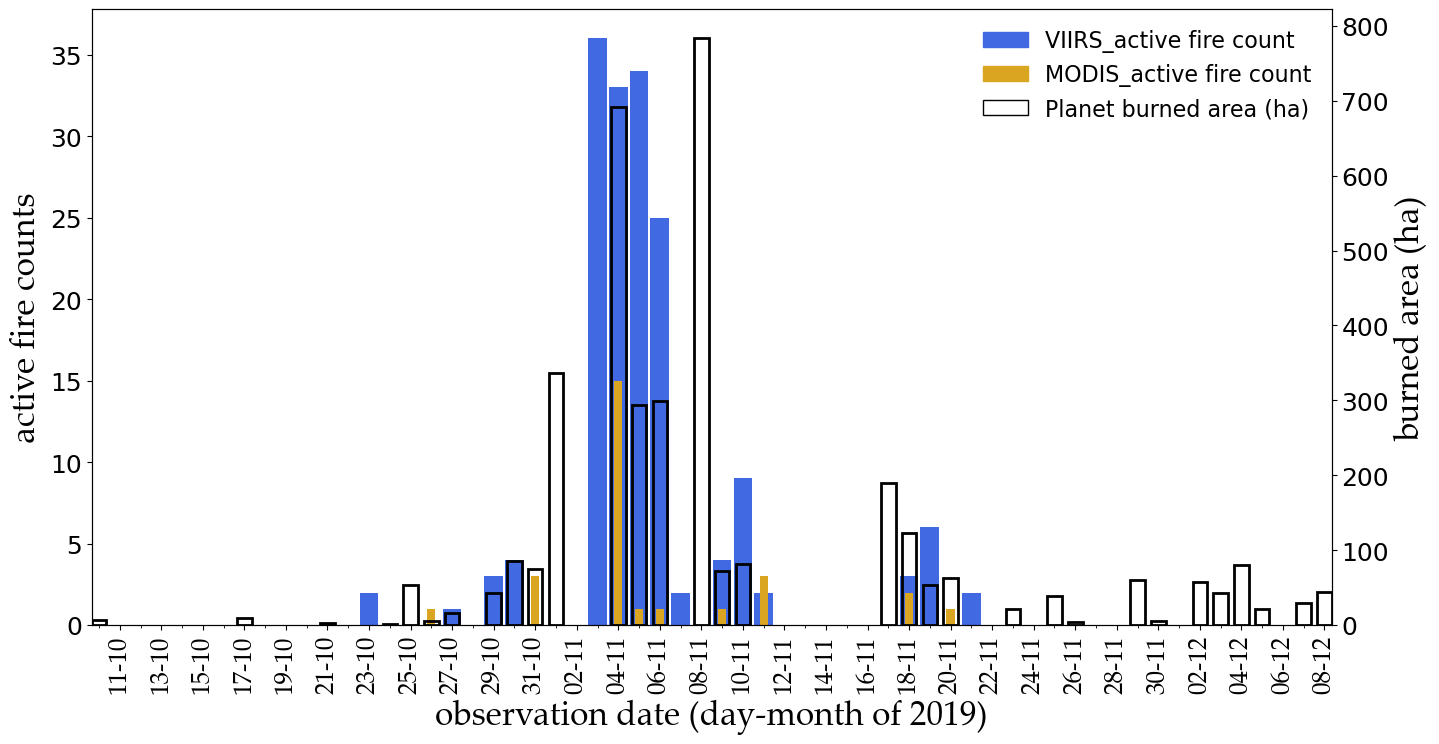

In [20]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

fig, ax1 = plt.subplots(figsize=(16,8))
ax1.margins(x=0)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.bar(viirs_doy.index, viirs_doy['counts'], color='royalblue', width=.9)
ax1.bar(modis_doy.index, modis_doy['counts'], color='goldenrod', width=0.4)
ax1.set_ylabel('active fire counts', fontsize = 24, fontname='Palatino Linotype') 
ax1.set_xlabel('observation date (day-month of 2019)', fontsize = 24, fontname='Palatino Linotype')

ax2 = ax1.twinx()
ax2.margins(x=0)
ax2.bar(planet_doy.index, planet_doy.ha, width=.7, color='none',edgecolor='black', linewidth=2)
#plt.xticks(ticks=range(0, (viirs_bydate.index[-1] - viirs_bydate.index[0] ).days))
ax1.set_xticklabels(date_labels, rotation='vertical', fontname='Palatino Linotype')
plt.tick_params(axis='x', labelrotation=45, labelsize=18)
ax2.set_ylabel('burned area (ha)', fontsize = 24, fontname='Palatino Linotype') 

viirs = mpatches.Patch(color='royalblue', label='VIIRS_active fire count')
modis = mpatches.Patch(color='goldenrod', label='MODIS_active fire count')
planet = mpatches.Patch(fc='none', ec='black', label='Planet burned area (ha)')
ax1.legend(handles=[viirs,modis,planet], loc='upper right', fontsize="16", frameon=False)

ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

plt.show()